# Preprocessing Wellington Data

**This dataset includes raw data required to calculate carbon emissions, our focus is on studying the decrease in carbon emissions for buses primarily designated for reducing carbon emissions, rather than buses primarily utilized for passenger transportation.**

**While weekend buses tend to be predominantly employed for passenger transportation, it's important to note that weekday buses also serve as a means of passenger transport. However, during weekdays, buses take on an additional role: they are strategically utilized for carbon reduction efforts, particularly during peak hours like 7am-9am and 4pm-6pm.**

### NetBI

The following dimensions were used to generate the datasets

X:
- Actual Running Time
- Actual In-Service KM
- Passenger Km
- Scheduled In-Service Km
- Cancelled Trips
- Sched Running Time per Trip

Y:
- Data
- Route
- Route Variant
- Direction
- Trip Number
- Actual Vehicle Type
- Vehicle Number
- Vehicle Emissions Standard
- Start Minute(Sched)
- Day

### Goals

- Split running time into, hourly run time intervals
- <input type="checkbox" checked> Calculate Average speed of a bus (distance/time) <input type="checkbox" checked> 
- <input type="checkbox" checked> Calculate Average Occupancy (passenger Km/ actual km <input type="checkbox" checked> 
- <input type="checkbox" checked> Calculate Carbon for routes <input type="checkbox" checked>
- <input type="checkbox" checked> Calculate the per person carbon emissions reduction
- tidy up emissions calculations description based on latest info from Josh
- <input type="checkbox" checked> Some emissions calculations show below zero. I was able to solve that by data cleaning <input type="checkbox" checked>

### Further Goals

- Create Heat Map
- Learn how to upload data to mongoDB
- Integrate heat map into Bean

 - please note, that this analysis does not account for canclelled buses, only those that ran. We have no time to fit this part of analysis in.
 

### Where I left off on 6 September (Oxana):

- Trying to create an itneractive plot
- thinking what should be on X and Y axis of the plot, which should be the filters?
- Also at this stage could not figure out how to explort the interactive plot outside of python

### Where I left off on 13 September (Oxana):

- <input type="checkbox" checked> merged trips data with fleetmaster to find out tareWeight of each bus. About 30% of info missing, checking with Hamish on this.
- <input type="checkbox" checked>created function that calculates emissions
-<input type="checkbox" checked> added the column to the data that calculates emissions
- <input type="checkbox" checked> need to add another calc for emissions for ELECTRIC bus, perhaps its just zero, did not have time to find out<input type="checkbox" checked> 
- <input type="checkbox" checked> Cleaned up data
-  I think when we miss bus Tare weight, emissions calc becomes zero, therefore diluting true emissions size. Think how to fix this.
- after the above is ironed out, need to aggregate the data per route per weekday and per hour of the day
- next plot it

### Where I left off on 19 September (Oxana):

- <input type="checkbox" checked> plotted the data in 4 plots: 2 for emissions value on weekdays and weekends and 2 for emissiona savings on weekdays and weekends.
- <input type="checkbox" checked> option 1) scatterplot with a dot per trip. COnsidering there are million+ records, a lot fo dots are hidden behild other dots?
- <input type="checkbox" checked>option 2) Inomved y scale to go by hour
- <input type="checkbox" checked>option 3) aggregated data by route, start time and weekday.
 - there are 900+ unique Stat Times, so perhaps we will need to aggregate by hour after all.
- created some basic interactive plots to attempt exporting them out of python. Exporting is a complicated step and I read a few articles about it, but have not figured out. 
- Most imporant next step is to figure out how to explort any plot with interactive functionality out of pyton environment


### Loading Data

In [1]:
#I needed to install dash first
# pip install dash


import pandas as pd
import numpy as np
import plotly.express as px
from ipywidgets import interact, widgets
import plotly.graph_objs as go
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
#read in data from Hamish. This dataframe contains all trips for FY2022/2023

wlgt2022_trips = pd.read_csv('Wellington Raw Data/trips_updated_2022-01-01_to_2023-06-30.csv')

In [3]:
wlgt2022_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688950 entries, 0 to 1688949
Data columns (total 19 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   Unnamed: 0                   1688950 non-null  int64  
 1   Date                         1688950 non-null  object 
 2   Route                        1688950 non-null  object 
 3   Route Variant                1688950 non-null  object 
 4   Direction                    1688950 non-null  object 
 5   Service Type                 1688950 non-null  object 
 6   Trip Number                  1688950 non-null  int64  
 7   Vehicle Number               1688950 non-null  object 
 8   Actual Vehicle Type          1688950 non-null  object 
 9   Vehicle Emissions Standard   1688950 non-null  object 
 10  Start Minute (Sched)         1688950 non-null  object 
 11  Actual Running Time          1688950 non-null  int64  
 12  Sched Running Time per Trip  1688950 non-n

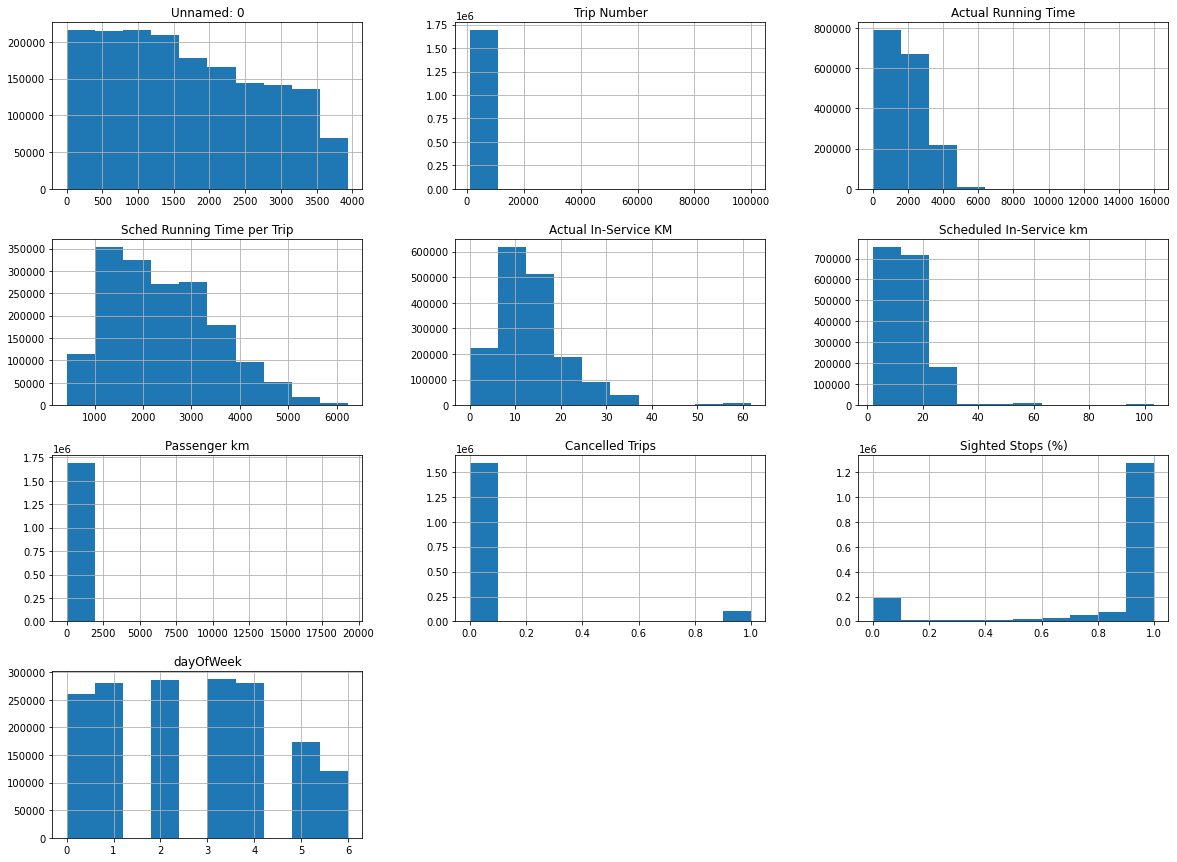

In [4]:
# look an numerical columns
wlgt2022_trips.hist(figsize=(20,15));
fig = plt.gcf()

#### Observations:

- Passenger km over 10 000 looks unrealistic
- sheduled and actual running time over 10,000 also looks unrealistic
- 

In [5]:
#data cleaning
wlgt2022_trips = wlgt2022_trips.drop(columns=['Unnamed: 0', 'dayOfWeek'])
wlgt2022_trips['Date'] = pd.to_datetime(wlgt2022_trips['Date'])
wlgt2022_trips['Start Minute (Sched)'] = pd.to_datetime(wlgt2022_trips['Start Minute (Sched)'], format='%H:%M').dt.time
wlgt2022_trips['Day of Week'] = wlgt2022_trips['Date'].dt.strftime('%A')

In [6]:
wlgt2022_trips.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1688950 entries, 0 to 1688949
Data columns (total 18 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   Date                         1688950 non-null  datetime64[ns]
 1   Route                        1688950 non-null  object        
 2   Route Variant                1688950 non-null  object        
 3   Direction                    1688950 non-null  object        
 4   Service Type                 1688950 non-null  object        
 5   Trip Number                  1688950 non-null  int64         
 6   Vehicle Number               1688950 non-null  object        
 7   Actual Vehicle Type          1688950 non-null  object        
 8   Vehicle Emissions Standard   1688950 non-null  object        
 9   Start Minute (Sched)         1688950 non-null  object        
 10  Actual Running Time          1688950 non-null  int64         
 11  Sched Runni

In [7]:
#remove what I think are trains
wlgt2022_trips = wlgt2022_trips[~wlgt2022_trips['Route'].str.contains('[a-zA-Z]')]

In [8]:
#replace unreaslistic actual running time with scheduled running time using arbitrary rule that if actual time is 
#greater than 5 times different from sheduled, something is wrong
wlgt2022_trips['Actual Running Time'] = np.where(
    (wlgt2022_trips['Actual Running Time'] != 0) & 
    (wlgt2022_trips['Actual Running Time'] / wlgt2022_trips['Sched Running Time per Trip'] > 5),
    wlgt2022_trips['Sched Running Time per Trip'],
    wlgt2022_trips['Actual Running Time']
)

**Bus Speed**

The calculation of bus speed is straightforward and involves the formula where velocity equals the ratio of distance to time ( $ v = \frac{d}{t} $ ).

Since Actual Running Time is in seconds, we divide the time by 3600 to get speed in km her hour.

In [9]:
#Calculate Average speed of a bus (distance/time) with a condition to avoid division by zero
wlgt2022_trips['Speed'] = np.where(wlgt2022_trips['Actual Running Time'] != 0,
                                    wlgt2022_trips['Actual In-Service KM'] / (wlgt2022_trips['Actual Running Time'] / 3600),
                                    0)  # Set Speed to 0 when Running Time is 0

 **Observation**
- Speed above 80km is unrealistic. There are 27766 rows like that. We will replace uprealistic speed with median speed.

In [10]:
wlgt2022_trips['Speed'].describe()

count    1.583838e+06
mean     2.594802e+01
std      5.551224e+01
min      0.000000e+00
25%      1.766890e+01
50%      2.326393e+01
75%      2.969914e+01
max      4.010400e+04
Name: Speed, dtype: float64

In [11]:
wlgt2022_trips['Speed'] = np.where(
    (wlgt2022_trips['Speed'] > 80),
    wlgt2022_trips['Speed'].median(),
    wlgt2022_trips['Speed']
)

**Average Occupancy**

 Mean occupancy (per kilometre driven) equals the ratio Passenger km to Actual In-Service KM
 
 Where Passenger km is a unit of measurement representing the transport of 1 passenger over 1 km
 and Actual In-Service KM is the lengh of a trip


In [12]:
wlgt2022_trips['Average Occupancy'] = np.where(wlgt2022_trips['Actual In-Service KM'] != 0,
                                               wlgt2022_trips['Passenger km']/wlgt2022_trips['Actual In-Service KM'],
                                               0) # Set Occupancy to 0 when Distance travelled is 0

In [13]:
# look into data that we have on Engine Type:
wlgt2022_trips['Vehicle Emissions Standard'].value_counts()
    

EURO6       817494
ELECTRIC    310687
EURO5       160695
Unknown     151436
EURO3        97730
EURO4        45796
Name: Vehicle Emissions Standard, dtype: int64

**Tare Weight**

In [14]:
# Now look up tareWeight of each bus
wlgt2022_fleetmaster = pd.read_csv('Wellington Raw Data/fleet_master.csv')
# Convert the 'Date Modified' column to datetime
wlgt2022_fleetmaster['Date Modified'] = pd.to_datetime(wlgt2022_fleetmaster['Date Modified'], format='%d/%m/%Y')

# filter fleetmaster to leave latest 'Date Modified' data only 
wlgt2022_fleetmaster = wlgt2022_fleetmaster.loc[wlgt2022_fleetmaster.groupby('Vehicle Number')['Date Modified'].idxmax()]

In [15]:
wlgt2022_fleetmaster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 622 entries, 7988 to 8606
Data columns (total 18 columns):
 #   Column                                   Non-Null Count  Dtype         
---  ------                                   --------------  -----         
 0   Date Modified                            622 non-null    datetime64[ns]
 1   Vehicle Number                           622 non-null    object        
 2   Operator                                 622 non-null    object        
 3   Operator Short Code                      622 non-null    object        
 4   Operator Prefix                          622 non-null    object        
 5   Unit Number                              536 non-null    object        
 6   Mode                                     622 non-null    object        
 7   Date of First Registration               573 non-null    object        
 8   Date of Manufacture                      563 non-null    object        
 9   Bike Rack Capable                      

In [16]:
# add tare Weight info to wlgt2022_trips by merging wlgt2022_trips with wlgt2022_fleetmaster
wlgt2022_trips_merged = wlgt2022_trips.merge(wlgt2022_fleetmaster[['Vehicle Number', 'TARE Weight (KG)']], on='Vehicle Number', how='left')


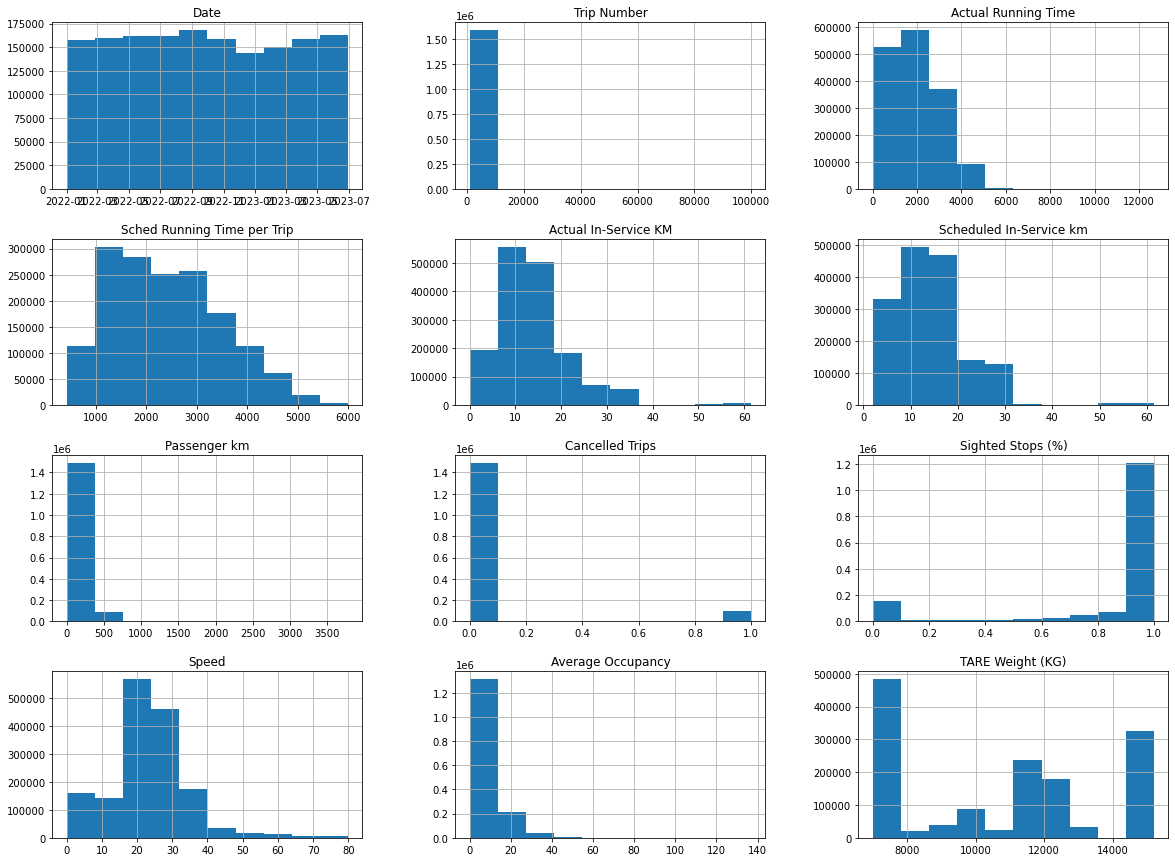

In [17]:
# look an numerical columns
wlgt2022_trips_merged.hist(figsize=(20,15));
fig = plt.gcf()

#### Observations
- passenger km over 1000 or so look unrealistic. Need to ask Chris about this.
- There are 92 buses with average occupancy over 100, they appear to be school buses.

# Calculate Emissions

In [18]:
#this cell is entering all the constants needed for calcs

LUBE = 0.265170857776354
PASSENGERWEIGHT = 80         #average passenger weight
DIESELDENSITY = 835          # grams per litre
CO2ELECTRIC = 119
emission_equations = [
    {
        "_id": "EURO6",
        "a": -0.00000490907972998,
        "b": -0.0138698794326,
        "g": 2.65774563711,
        "d": 3.2553615439,
        "e": -0.000051285329923,
        "z": 0.00498758025146,
        "h": 0.125550793946
    },
    {
        "_id": "EURO5",
        "a": -0.0000367698590941,
        "b": -0.0134678044879,
        "g": 3.05911007786,
        "d": 3.55505145507,
        "e": -0.0000618780508159,
        "z": 0.00594233596222,
        "h": 0.142419853084
    },
    {
        "_id": "EURO4",
        "a": 0.00251040331347,
        "b": -0.0863970747847,
        "g": 1.10983487462,
        "d": 14.7776496863,
        "e": 0.000327986189114,
        "z": -0.0130053588546,
        "h": 0.218081753103
    },
    {
        "_id": "EURO3",
        "a": 0.00000421475875959,
        "b": 0.0207160939587,
        "g": 1.73463013954,
        "d": 7.0692144528,
        "e": -0.0000197902932034,
        "z": 0.0062379661034,
        "h": 0.0627620452536
    },
    {
        "_id": "EURO2",
        "a": 0.00000840769603463,
        "b": 0.0200800121334,
        "g": 1.65858316407,
        "d": 6.77362500033,
        "e": -0.0000201599863213,
        "z": 0.00634399262596,
        "h": 0.0638032158354
    },
    {
        "_id": "EURO1",
        "a": -0.00000137497057894,
        "b": 0.0209960875758,
        "g": 1.88066742017,
        "d": 7.94657629399,
        "e": -0.0000215438923697,
        "z": 0.00682789815225,
        "h": 0.00682789815225
    },
    {
        "_id": "PREEURO",
        "a": -0.00000656462584868,
        "b": 0.0178339567319,
        "g": 1.79325857679,
        "d": 7.7207331411,
        "e": -0.0000181010843656,
        "z": 0.00549860697303,
        "h": 0.045663294005
    }
]

#The following are 
CH4 = {
    "PREEURO": 0.175,
    "EURO1": 0.175,
    "EURO2": 0.11375,
    "EURO3": 0.10325,
    "EURO4": 0.00525,
    "EURO5": 0.00525,
    "EURO6": 0.00525,
    "CO2FACTOR": 25
}

# N2O.CO2FACTOR converts the N20 realsed to its C02 equivilent. 
# This is to say, how much greenhouse effect does this have over its time in the apnosphere. 
# How much CO2 is needed to have the same effect as this much N20. 
# The numbers we have in the code are used by a previous group however I did my own research and found slightly different numbers. I really want to put them in but I don't know where their numbers come from and I can't find any through research.

# CalcN20 is the greenhouse effectivness of N20 compared to CO

# Just looking at this it looks wrong.
# I would think taht the numbers would decrease as the euros get smaller, not increase. 
# I think that it is reasonable to say that the numbers are the wrong way around. 
# However for consistency with BEAn I am keeping it as is.
N2O = {
    "PREEURO"  : 0.030,            
    "EURO1"     : 0.012,
    "EURO2"     : 0.012,
    "EURO3"     : 0.006,
    "EURO4"     : 0.0128,
    "EURO5"     : 0.0332,
    "EURO6"     : 0.0415,
    "CO2FACTOR": 298
}

In [19]:
# this cell defines a function for emissions calculation

# calculate the emissions in grams per KM


# You can access the dictionary for each engine using the engine name as the key.

def calcCO2equiv(row):
    
    
    tareWeight = row['TARE Weight (KG)'] 
    aveOccupancy = row['Average Occupancy'] 
    distance = row['Actual In-Service KM']
    speed = row['Speed']
    euro = row['Vehicle Emissions Standard']
    
    if speed == 0:
        CO2emissions = 0 
    elif euro == 'ELECTRIC':
        CO2emissions = distance*CO2ELECTRIC/1000 
    elif euro =='Unknown':
        CO2emissions = np.nan
    else:
        for item in emission_equations: #looking up values for calculating fuel consumption depending on engine type
            if item["_id"] == euro:
                a = item["a"]
                b = item["b"]
                g = item["g"]
                d = item["d"]
                e = item["e"]
                z = item["z"]
                h = item["h"]

                
        # **Step 1.** Calculate weight factors:

        loadedWeight = tareWeight + aveOccupancy * PASSENGERWEIGHT
        tareFactor =   (0.00004711 * tareWeight) + 0.446
        loadedFactor = (0.00004711 * loadedWeight) + 0.446
        # **Step 2** Calculate fuelConsumed
        fuelConsumedStandard = 100/(45.79 * DIESELDENSITY/1000)*(a * speed**2+b * speed+g+d/speed)/(e*speed**2 + z*speed + h) #L/lm
        #note: ** is power operator (^)
        fuelConsumedAdjusted = fuelConsumedStandard * (loadedFactor * distance + tareFactor * distance*0.15) 
        # note: distance*0.15 is repositioning distance 
        # The 0.15 is accounting for an approximation 15% of the journey the bus travels to either get back to the bus depo or start the next route
        # **Step 3** Calculate fuelEmissions
        fuelEmissions = fuelConsumedAdjusted * 69.31 * DIESELDENSITY * 45.79/100000 #69.31 is CO2 emission factor (tCO2/TJ)
        oilEmissions = distance * LUBE
        CO2emissions = fuelEmissions + oilEmissions
        
        #**Step 4.** Add emissions from all pollutants: 
        CH4Emissions = distance * CH4[euro] * CH4['CO2FACTOR']
        N2OEmissions = distance * N2O[euro] * N2O['CO2FACTOR']
        
               
    return CO2emissions
    
    

In [20]:
wlgt2022_trips_merged['CO2emissions'] = wlgt2022_trips_merged.apply(calcCO2equiv, axis = 1)

In [21]:
wlgt2022_trips_merged['CO2emissions'].describe()

count    1.542889e+06
mean     8.428237e+03
std      7.997249e+03
min      0.000000e+00
25%      2.054416e+00
50%      7.399072e+03
75%      1.263154e+04
max      6.018665e+04
Name: CO2emissions, dtype: float64

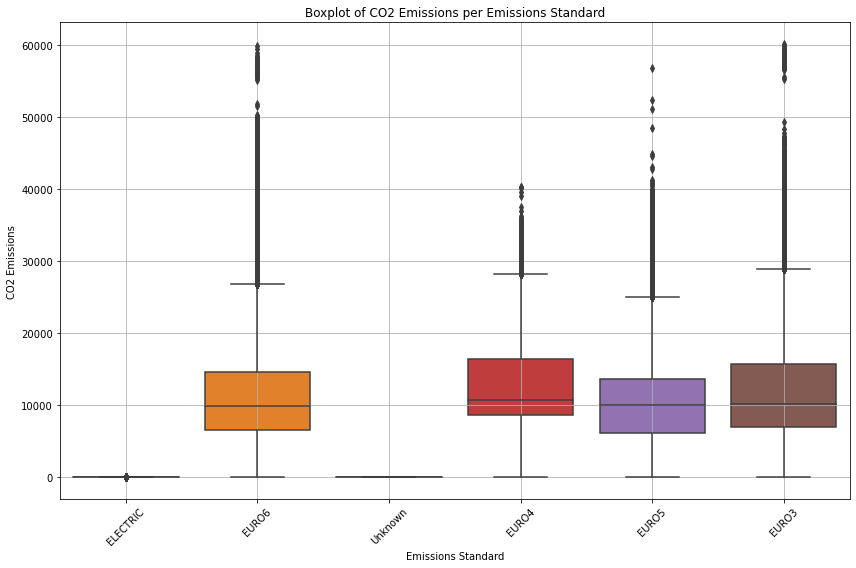

In [22]:
# just checking how this looks:
import seaborn as sns
import matplotlib.pyplot as plt

forPlot = wlgt2022_trips_merged.copy()
forPlot['CO2emissions'] = pd.to_numeric(forPlot['CO2emissions'], errors='coerce')

plt.figure(figsize=(12, 8))
sns.boxplot(x='Vehicle Emissions Standard', y='CO2emissions', data=forPlot)
plt.xticks(rotation=45)
plt.xlabel('Emissions Standard')
plt.ylabel('CO2 Emissions')
plt.title('Boxplot of CO2 Emissions per Emissions Standard')
plt.grid(True)
plt.tight_layout()
plt.show()

## Calculate CO2 savings* 
**\*saved emissions as a result of taking a bus compared to car**

**Average car occupancy**

We use the assumption that on average 1.3 passengers travel in each car. To calculate how many Car km it would take to transport the same number of passengers we divide Passenger km by 1.3

**CO_2 emissions**

CO_2 are taken to be 0.265 kg per Car km. 
To calculate how much CO_2 would be emitted if the bus passengers travelled by a private car we use the following calculation:
$$ CO_2 emissions = \frac{0.265\times Passenger km}{1.3} $$

**Valuation of CO_2 emissions**

The whole-of-government agreed shadow price of carbon ($ per tonne of CO2 equivalent) emissions, in Table 1, is to be used for calculating the economic impact of carbon for transport activities.  This means applying the **central** price path as the default analysis in the economic evaluation of transport proposals and accompanying this with sensitivity analysis based on the low and high price paths. Quoted from here: https://www.nzta.govt.nz/assets/resources/monetised-benefits-and-costs-manual/Monetised-benefits-and-costs-manual.pdf

Table 1: Shadow Price of Carbon (NZ$2022 per tonne of CO2 equivalent)



| Year  | 2023  | 2024  | 2025  | 2026  | 2027  | 2028  | 2029  | 2030  | 2031  | 2032  | 2033  | 2034  |
|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| Low   | \$59  | \$65  | \$72  | \$78  | \$85  | \$91  | \$98  | \$104 | \$108 | \$112 | \$116 | \$120 |
| Middle| \$87  | \$97  | \$107 | \$116 | \$126 | \$136 | \$146 | \$155 | \$161 | \$167 | \$174 | \$180 |
| High  | \$171 | \$182 | \$193 | \$203 | \$214 | \$219 | \$224 | \$230 | \$235 | \$241 | \$247 | \$253 |


Therefore the calculation for shadow cost of CO_2 if the same trip was taken by private cars looks as follows:
(dividing by 1000 as price is per tonne)

$$ CO_2 shadow \ cost = \frac{0.265\times Passenger km\times \$\ Middle \ price for 2023}{1.3\times1000} $$

Please note that part of our data is from 2022, so technically we should be using 2022 price for that part:
Should your analysis require shadow prices for years prior to 2023, email MBCM@nzta.govt.nz.  

In [23]:
#you can update shadow price here if you want to use it for a different year
shadow_price2023 = 87

wlgt2022_trips_merged['emissions savings'] = wlgt2022_trips_merged['Passenger km']*0.265*shadow_price2023/(1.3*1000)

In [24]:
# calculate dollar value of emissions from bus trips
# CO2emissions are in gramms, price is per tonne, so we divide by 10^6 to covnert
wlgt2022_trips_merged['emissions $value'] = wlgt2022_trips_merged['CO2emissions']*shadow_price2023/10**6

**aggregating the data for plotting**


**Aggregating data**

by "Route", "Day of Week", "Start Minute (Sched)" 

In [25]:
# grouping data that is split by the hour

wlgt2022_trips_merged['CO2emissions'] = pd.to_numeric(wlgt2022_trips_merged['CO2emissions'], errors='coerce')

# Group by "Route," "Day of Week," and "Start Minute" and aggregate using desired functions

wlgt2022_trips_aggregated_by_route = wlgt2022_trips_merged.groupby(["Route", "Day of Week", "Start Minute (Sched)"]).agg({
    "Trip Number": "count",  # Count of trips
    "Actual Running Time": "mean",  # Mean of running times
    "Actual In-Service KM": "sum",  # Sum of scheduled in-service km
    "Passenger km": "sum",  # Sum of passenger km
    'Speed': "mean",
    'Average Occupancy': 'mean',
    "CO2emissions": "sum",  # Calculate sum of CO2emissions
    'emissions $value': "sum",
    'emissions savings': "sum"
}).reset_index()

# rename the columns for clarity
wlgt2022_trips_aggregated_by_route.columns = ["Route", "Day of Week", "Start Minute (Sched)", "Trip Count", "Mean Running Time",
                         "Total Actual In-Service KM", "Total Passenger KM", "Mean Speed", "Mean Occupancy", 
                         "Total CO2 Emissions", "Total emissions $value", "Total emissions savings"]

In [26]:
wlgt2022_trips_aggregated_by_route.to_csv("wlgt2022_trips_aggregated_by_route.csv")
wlgt2022_trips_aggregated_by_route.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27259 entries, 0 to 27258
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Route                       27259 non-null  object 
 1   Day of Week                 27259 non-null  object 
 2   Start Minute (Sched)        27259 non-null  object 
 3   Trip Count                  27259 non-null  int64  
 4   Mean Running Time           27259 non-null  float64
 5   Total Actual In-Service KM  27259 non-null  float64
 6   Total Passenger KM          27259 non-null  float64
 7   Mean Speed                  27259 non-null  float64
 8   Mean Occupancy              27259 non-null  float64
 9   Total CO2 Emissions         27259 non-null  float64
 10  Total emissions $value      27259 non-null  float64
 11  Total emissions savings     27259 non-null  float64
dtypes: float64(8), int64(1), object(3)
memory usage: 2.5+ MB


**Splitting data by the hour**

This workds, however it does not work if the start minute is at 23:something. Need to fix this.

In [3]:
from datetime import datetime, timedelta
# Function to split rows by hour
def split_rows_by_hour(row):
    columns_list = ["Total Actual In-Service KM", "Total Passenger KM",
                    "Total CO2 Emissions", "Total emissions savings", "Total emissions $value"] #these columns will be updated proportionately
    start_minute = pd.to_datetime(row["Start Minute (Sched)"], format = "%H:%M:%S")
    total_time = row["Mean Running Time"]
    step = 3600  # Split every hour, since our data is in seconds
    rows = []

    while total_time > 0:
        new_row = row.copy()
        new_row["Trip Hour"] = "{:02d}:00".format(start_minute.hour)
        
        if total_time >= step - start_minute.minute*60:
            new_row["Mean Running Time"] = step-start_minute.minute*60
        else:
            new_row["Mean Running Time"] = total_time

        proportion = new_row["Mean Running Time"] / row["Mean Running Time"]
        for column in columns_list:
            new_row[column] = row[column] * proportion
        rows.append(new_row)
        total_time -= new_row["Mean Running Time"]
        start_minute += timedelta(hours=1)
        start_minute = start_minute.replace(minute=0, second=0)

    return pd.DataFrame(rows)

In [4]:
wlgt2022_trips_by_hour = pd.concat(
    wlgt2022_trips_aggregated_by_route.apply(split_rows_by_hour, axis=1).tolist(),
    ignore_index=True
)

In [6]:
wlgt2022_trips_by_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39636 entries, 0 to 39635
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  39636 non-null  int64  
 1   Route                       39636 non-null  int64  
 2   Day of Week                 39636 non-null  object 
 3   Start Minute (Sched)        39636 non-null  object 
 4   Trip Count                  39636 non-null  int64  
 5   Mean Running Time           39636 non-null  float64
 6   Total Actual In-Service KM  39636 non-null  float64
 7   Total Passenger KM          39636 non-null  float64
 8   Mean Speed                  39636 non-null  float64
 9   Mean Occupancy              39636 non-null  float64
 10  Total CO2 Emissions         39636 non-null  float64
 11  Total emissions $value      39636 non-null  float64
 12  Total emissions savings     39636 non-null  float64
 13  Trip Hour                   396

**Aggregate again**
- by "Route", "Day of Week", "Trip Hour"

In [7]:
wlgt2022_trips_by_hour_aggregated = wlgt2022_trips_by_hour.groupby(["Route", "Day of Week", "Trip Hour"]).agg({
    "Trip Count": "sum",  # Count of trips
    "Mean Running Time": "mean",  # Mean of running times
    "Total Actual In-Service KM": "sum",  # Sum of scheduled in-service km
    "Total Passenger KM": "sum",  # Sum of passenger km
    'Mean Speed': "mean",
    'Mean Occupancy': 'mean',
    "Total CO2 Emissions": "sum",  # Calculate sum of CO2emissions
    'Total emissions $value': "sum",
    'Total emissions savings': "sum"
}).reset_index()


In [16]:
wlgt2022_trips_by_hour_aggregated.to_csv("wlgt2022_trips_by_hour_aggregated.csv")

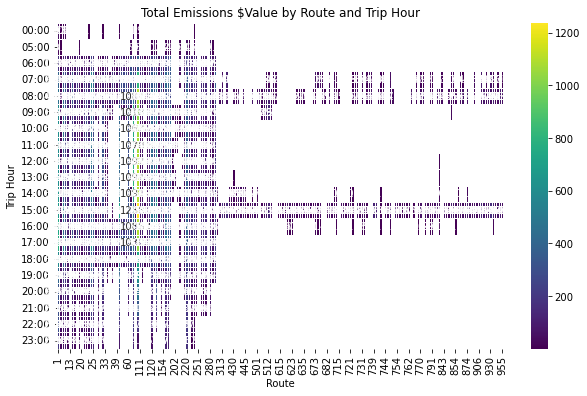

In [14]:
import seaborn as sns
# Create a heatmap to visualize the data
# Create a heatmap to visualize the data
pivot_table = wlgt2022_trips_by_hour_aggregated.pivot_table(index='Trip Hour', columns='Route', values='Total emissions $value')

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='viridis', annot=True, fmt='.1f', linewidths=.5)
plt.title('Total Emissions $Value by Route and Trip Hour')
plt.xlabel('Route')
plt.ylabel('Trip Hour')
plt.show()

C:\Users\oxant\AppData\Local\Temp\ipykernel_9728\2652201949.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
C:\Users\oxant\AppData\Local\Temp\ipykernel_9728\2652201949.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')


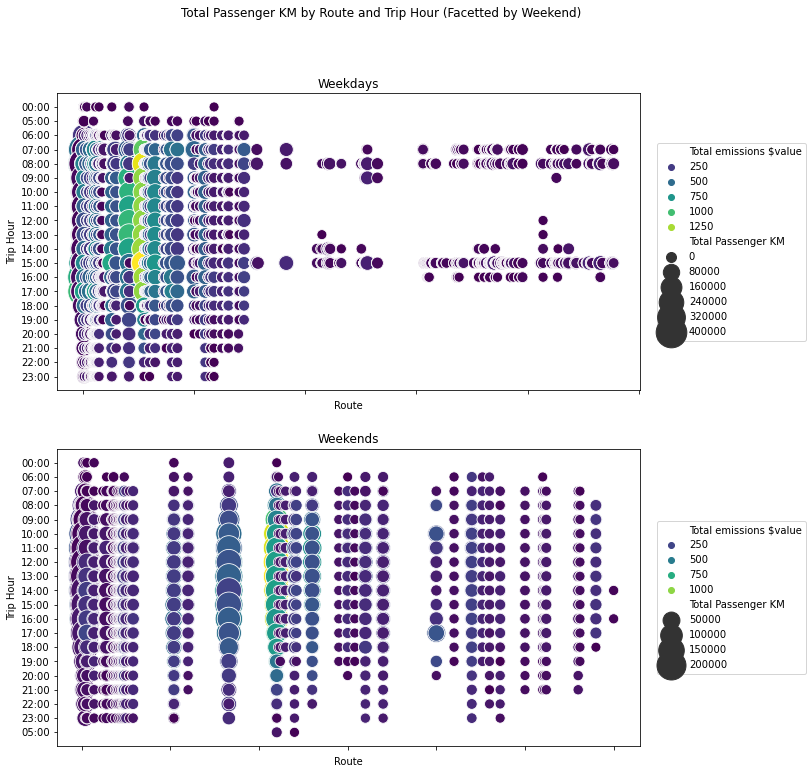

In [35]:
wlgt2022_trips_by_hour_aggregated['Weekend'] = wlgt2022_trips_by_hour_aggregated['Day of Week'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')


# Create a facetted heatmap for weekdays and weekends
weekdays_df = wlgt2022_trips_by_hour_aggregated[wlgt2022_trips_by_hour_aggregated['Weekend'] == 'Weekday']
weekends_df = wlgt2022_trips_by_hour_aggregated[wlgt2022_trips_by_hour_aggregated['Weekend'] == 'Weekend']

fig, axes = plt.subplots(2, 1, figsize=(12, 12))
fig.suptitle('Total Passenger KM by Route and Trip Hour (Facetted by Weekend)')

for i, (day, day_df) in enumerate(zip(['Weekdays', 'Weekends'], [weekdays_df, weekends_df])):
    ax = axes[i]
    sns.scatterplot(data=day_df, x='Route', y='Trip Hour', size='Total Passenger KM', hue='Total emissions $value',
                    palette='viridis', sizes=(100, 1000), ax=ax)
    ax.set_title(day)
    ax.set_xlabel('Route')
    ax.set_ylabel('Trip Hour')

    # Set the X-axis as categorical
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

    # Move the legend to the right
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

# Adjust spacing between subplots
fig.subplots_adjust(right=0.8)

plt.show()

**Plots for raw unaggregated data**

C:\Users\oxant\AppData\Local\Temp\ipykernel_21764\753169508.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekday_data['emissions savings bins'] = pd.cut(weekday_data['emissions savings'], bins=bins, labels=labels)
C:\Users\oxant\AppData\Local\Temp\ipykernel_21764\753169508.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weekend_data['emissions savings bins'] = pd.cut(weekend_data['emissions savings'], bins=bins, labels=labels)
C:\Users\oxant\AppData\Local\Temp\ipykernel_21764\753169508.py:37: U

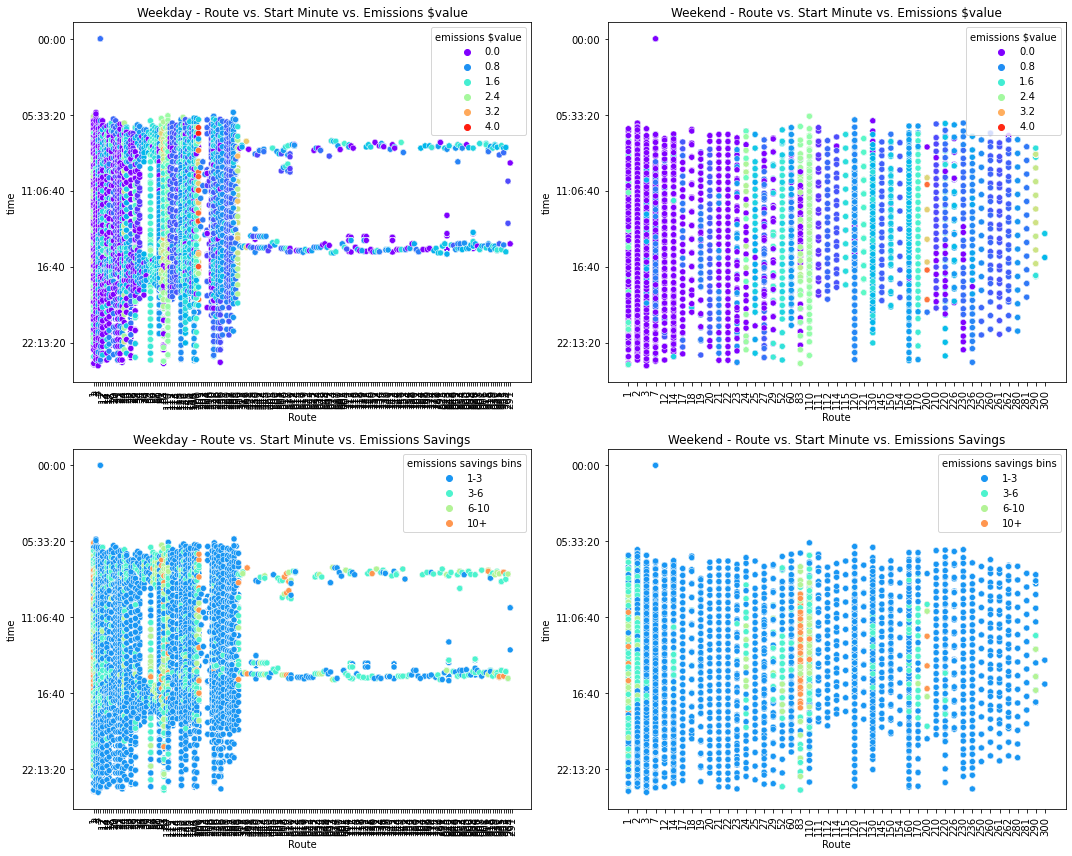

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Separate data for weekdays and weekends
weekday_data = wlgt2022_trips_merged[wlgt2022_trips_merged['Day of Week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekend_data = wlgt2022_trips_merged[wlgt2022_trips_merged['Day of Week'].isin(['Saturday', 'Sunday'])]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Weekday - Route vs. Start Minute vs. Emissions $value
sns.scatterplot(data=weekday_data, x='Route', y='Start Minute (Sched)', hue='emissions $value', palette='rainbow', ax=axes[0, 0])
axes[0, 0].set_title('Weekday - Route vs. Start Minute vs. Emissions $value')
axes[0, 0].tick_params(axis='x', rotation=90)

# Plot 2: Weekend - Route vs. Start Minute vs. Emissions $value
sns.scatterplot(data=weekend_data, x='Route', y='Start Minute (Sched)', hue='emissions $value', palette='rainbow', ax=axes[0, 1])
axes[0, 1].set_title('Weekend - Route vs. Start Minute vs. Emissions $value')
axes[0, 1].tick_params(axis='x', rotation=90)

# Create custom color bins for emissions savings
bins = [0, 3, 6, 10, np.inf]
labels = ['1-3', '3-6', '6-10', '10+']
weekday_data['emissions savings bins'] = pd.cut(weekday_data['emissions savings'], bins=bins, labels=labels)
weekend_data['emissions savings bins'] = pd.cut(weekend_data['emissions savings'], bins=bins, labels=labels)

# Plot 3: Weekday - Route vs. Start Minute vs. Emissions Savings
sns.scatterplot(data=weekday_data, x='Route', y='Start Minute (Sched)', hue='emissions savings bins', palette='rainbow', ax=axes[1, 0])
axes[1, 0].set_title('Weekday - Route vs. Start Minute vs. Emissions Savings')
axes[1, 0].tick_params(axis='x', rotation=90)

# Plot 4: Weekend - Route vs. Start Minute vs. Emissions Savings
sns.scatterplot(data=weekend_data, x='Route', y='Start Minute (Sched)', hue='emissions savings bins', palette='rainbow', ax=axes[1, 1])
axes[1, 1].set_title('Weekend - Route vs. Start Minute vs. Emissions Savings')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()



C:\Users\oxant\AppData\Local\Temp\ipykernel_21764\1197504582.py:45: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.tight_layout()


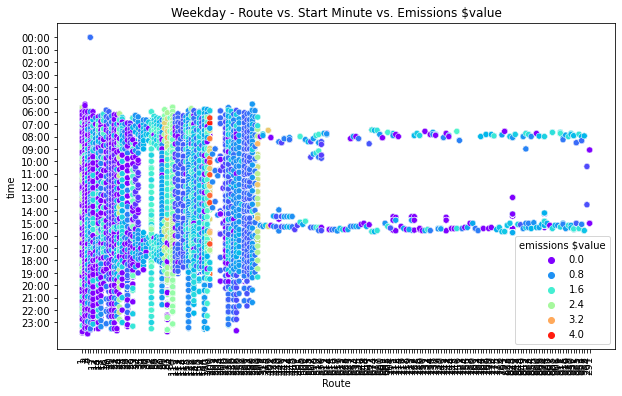

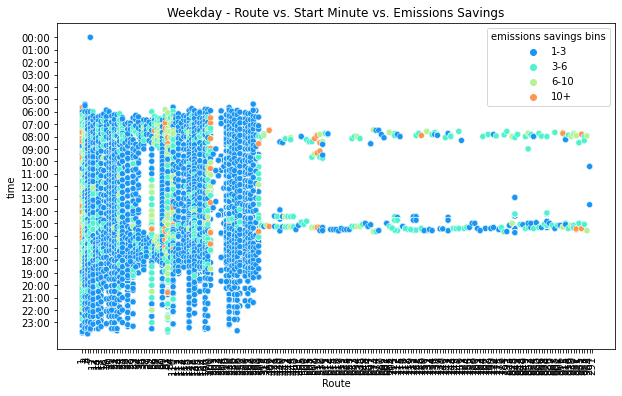

C:\Users\oxant\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


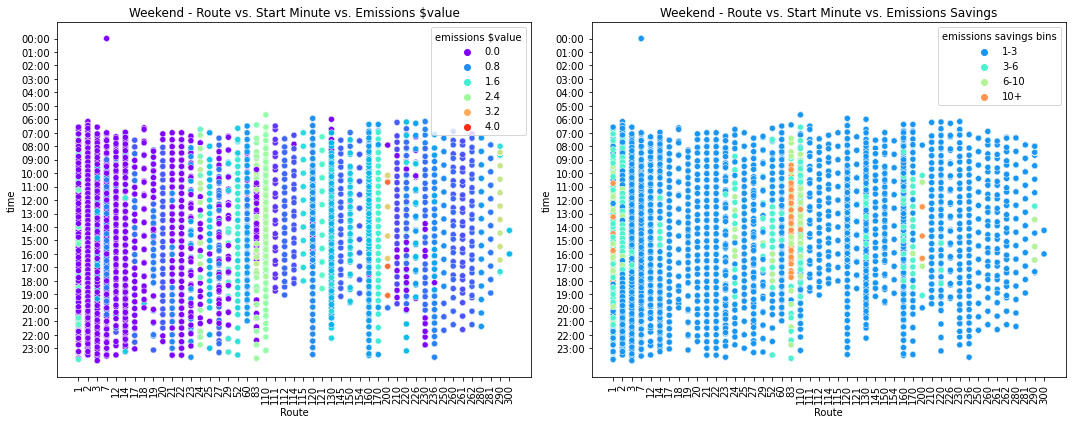

In [25]:
# Create separate figures for the first two plots
fig1, ax1 = plt.subplots(figsize=(10, 6))
fig2, ax2 = plt.subplots(figsize=(10, 6))

# Plot 1: Weekday - Route vs. Start Minute vs. Emissions $value
sns.scatterplot(data=weekday_data, x='Route', y='Start Minute (Sched)', hue='emissions $value', palette='rainbow', ax=ax1)
ax1.set_title('Weekday - Route vs. Start Minute vs. Emissions $value')
ax1.tick_params(axis='x', rotation=90)

# Set y-axis ticks for hours of the day
ax1.set_yticks(pd.date_range(start='00:00', end='23:00', freq='1H').time)

# Plot 3: Weekday - Route vs. Start Minute vs. Emissions Savings
sns.scatterplot(data=weekday_data, x='Route', y='Start Minute (Sched)', hue='emissions savings bins', palette='rainbow', ax=ax2)
ax2.set_title('Weekday - Route vs. Start Minute vs. Emissions Savings')
ax2.tick_params(axis='x', rotation=90)

# Set y-axis ticks for hours of the day
ax2.set_yticks(pd.date_range(start='00:00', end='23:00', freq='1H').time)

# Create a combined figure for the last two plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 2: Weekend - Route vs. Start Minute vs. Emissions $value
sns.scatterplot(data=weekend_data, x='Route', y='Start Minute (Sched)', hue='emissions $value', palette='rainbow', ax=axes[0])
axes[0].set_title('Weekend - Route vs. Start Minute vs. Emissions $value')
axes[0].tick_params(axis='x', rotation=90)

# Set y-axis ticks for hours of the day
axes[0].set_yticks(pd.date_range(start='00:00', end='23:00', freq='1H').time)

# Plot 4: Weekend - Route vs. Start Minute vs. Emissions Savings
sns.scatterplot(data=weekend_data, x='Route', y='Start Minute (Sched)', hue='emissions savings bins', palette='rainbow', ax=axes[1])
axes[1].set_title('Weekend - Route vs. Start Minute vs. Emissions Savings')
axes[1].tick_params(axis='x', rotation=90)

# Set y-axis ticks for hours of the day
axes[1].set_yticks(pd.date_range(start='00:00', end='23:00', freq='1H').time)

# Adjust layout for the combined figure
fig.tight_layout()

# Show all figures
plt.show()


**comment**
The above plots show one dot per trip. There are a million records, so a lot of dots are covered by othewr dots. Lets see what we can achieve by aggregating data.

In [26]:
# having a go at grouping data

wlgt2022_trips_merged['CO2emissions'] = pd.to_numeric(wlgt2022_trips_merged['CO2emissions'], errors='coerce')

# Group by "Route," "Day of Week," and "Start Minute" and aggregate using desired functions

aggregated_df = wlgt2022_trips_merged.groupby(["Route", "Day of Week", "Start Minute (Sched)"]).agg({
    "Trip Number": "count",  # Count of trips
    "Actual Running Time": "sum",  # Sum of running times
    "Actual In-Service KM": "sum",  # Sum of scheduled in-service km
    "Passenger km": "sum",  # Sum of passenger km
    'Speed': "mean",
    'Average Occupancy': 'mean',
    "CO2emissions": "sum",  # Calculate sum of CO2emissions
    'emissions $value': "sum",
    'emissions savings': "sum"
}).reset_index()

# rename the columns for clarity
aggregated_df.columns = ["Route", "Day of Week", "Start Minute (Sched)", "Trip Count", "Total Running Time",
                         "Total Actual In-Service km", "Total Passenger km", "Mean Speed", "Mean Occupancy", 
                         "Total CO2 Emissions", "Total emissions $value", "Total emissions savings"]

In [27]:
aggregated_df["Start Minute (Sched)"].nunique()

986

In [ ]:
# Separate data for weekdays and weekends
weekday_data = aggregated_df[aggregated_df['Day of Week'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]
weekend_data = aggregated_df[aggregated_df['Day of Week'].isin(['Saturday', 'Sunday'])]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Weekday - Route vs. Start Minute vs. Emissions $value
sns.scatterplot(data=weekday_data, x='Route', y='Start Minute (Sched)', hue='Total emissions $value', palette='rainbow', ax=axes[0, 0])
axes[0, 0].set_title('Weekday - Route vs. Start Minute vs. Emissions $value')
axes[0, 0].tick_params(axis='x', rotation=90)

# Plot 2: Weekend - Route vs. Start Minute vs. Emissions $value
sns.scatterplot(data=weekend_data, x='Route', y='Start Minute (Sched)', hue='Total emissions $value', palette='rainbow', ax=axes[0, 1])
axes[0, 1].set_title('Weekend - Route vs. Start Minute vs. Emissions $value')
axes[0, 1].tick_params(axis='x', rotation=90)

# Create custom color bins for emissions savings
bins = [0, 10, 40, 100, np.inf]
labels = ['1-10', '10-40', '40-100', '100+']
weekday_data['emissions savings bins'] = pd.cut(weekday_data['Total emissions savings'], bins=bins, labels=labels)
weekend_data['emissions savings bins'] = pd.cut(weekend_data['Total emissions savings'], bins=bins, labels=labels)

# Plot 3: Weekday - Route vs. Start Minute vs. Emissions Savings
sns.scatterplot(data=weekday_data, x='Route', y='Start Minute (Sched)', hue='emissions savings bins', palette='rainbow', ax=axes[1, 0])
axes[1, 0].set_title('Weekday - Route vs. Start Minute vs. Emissions Savings')
axes[1, 0].tick_params(axis='x', rotation=90)

# Plot 4: Weekend - Route vs. Start Minute vs. Emissions Savings
sns.scatterplot(data=weekend_data, x='Route', y='Start Minute (Sched)', hue='emissions savings bins', palette='rainbow', ax=axes[1, 1])
axes[1, 1].set_title('Weekend - Route vs. Start Minute vs. Emissions Savings')
axes[1, 1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [64]:
#attepmting interactive plots

import pandas as pd
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

app = dash.Dash(__name__)

# Layout of the web app
app.layout = html.Div([
    html.Label('Select Day of Week:'),
    dcc.Dropdown(
        id='day-dropdown',
        options=[{'label': day, 'value': day} for day in wlgt2022_trips['Day of Week'].unique()],
        value=wlgt2022_trips['Day of Week'].unique()[0]
    ),
    
    html.Label('Select Start Time (Sched):'),
    dcc.Dropdown(
        id='time-dropdown',
        options=[{'label': time, 'value': time} for time in wlgt2022_trips['Start Minute (Sched)'].unique()],
        value=wlgt2022_trips['Start Minute (Sched)'].unique()[0]
    ),
    
    dcc.Graph(id='co2-cost-plot')
])

# Callback function to update the plot based on dropdown selections
@app.callback(
    Output('co2-cost-plot', 'figure'),
    [Input('day-dropdown', 'value'), Input('time-dropdown', 'value')]
)
def update_plot(selected_day, selected_time):
    filtered_df = wlgt2022_trips[(wlgt2022_trips['Day of Week'] == selected_day) & (wlgt2022_trips['Start Minute (Sched)'] == selected_time)]
    
    fig = px.scatter(filtered_df, x='Date', y='CO2cost', title=f'CO2 Cost for {selected_day} - {selected_time}')
    
    fig.update_xaxes(title_text='Date')
    fig.update_yaxes(title_text='CO2 Cost')
    
    return fig

if __name__ == '__main__':
    app.run_server(debug=False)


In [90]:
# 2nd attempt, trying to explore what dimentions the plot should have
# check package tkinter, gui, flask app
app = dash.Dash(__name__)

# Layout of the web app
app.layout = html.Div([
    html.Label('Select Days of the Week:'),
    dcc.Checklist(
        id='day-checkboxes',
        options=[{'label': day, 'value': day} for day in wlgt2022_trips['Day of Week'].unique()],
        value=wlgt2022_trips['Day of Week'].unique()  # All days initially selected
    ),
    
    html.Label('Select Start Time (Sched):'),
    dcc.Dropdown(
        id='time-dropdown',
        options=[{'label': time, 'value': time} for time in wlgt2022_trips['Start Minute (Sched)'].unique()],
        value=wlgt2022_trips['Start Minute (Sched)'].unique()[0]
    ),
    
    html.Div(id='total-co2-cost'),  # Display the total CO2 cost
    dcc.Graph(id='co2-cost-plot')
])

# Callback function to update the plot based on checkbox selections and time dropdown
@app.callback(
    [Output('co2-cost-plot', 'figure'), Output('total-co2-cost', 'children')],
    [Input('day-checkboxes', 'value'), Input('time-dropdown', 'value')]
)
def update_plot(selected_days, selected_time):
    filtered_df = wlgt2022_trips[(wlgt2022_trips['Day of Week'].isin(selected_days)) & (wlgt2022_trips['Start Minute (Sched)'] == selected_time)]
    
    total_co2_cost = filtered_df['CO2cost'].sum()  # Calculate the total CO2 cost
    
    fig = px.scatter(filtered_df, x='Day of Week', y='CO2cost', title=f'CO2 Cost for Days of the Week - {selected_time}')
    
    fig.update_xaxes(title_text='Day of Week')
    fig.update_yaxes(title_text='CO2 Cost')
    
    return fig, f'Total CO2 Cost: {total_co2_cost:.2f}'

if __name__ == '__main__':
    app.run_server(debug=False)